In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [2]:
# Download data from open datasets. https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
sat_data = datasets.EuroSAT(
    root="data",
    download=True,
    transform=ToTensor(),
)
print(f"There are {len(sat_data)} images in this data set")

There are 27000 images in this data set


In [6]:
#here are the classes
class_labels = sat_data.find_classes('data/eurosat/2750/')[0]

In [7]:
class_labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [8]:
#label dictionary (taken from Kaggle link above)
label2int= sat_data.find_classes('data/eurosat/2750/')[1]
int2label = dict(zip(label2int.values(),label2int.keys()))

In [5]:
train_size =.8
test_size = .2
torch.manual_seed(0)
train_size = round(.8*len(sat_data))
training_data, testing_data = torch.utils.data.random_split(sat_data, [train_size, len(sat_data)-train_size])

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


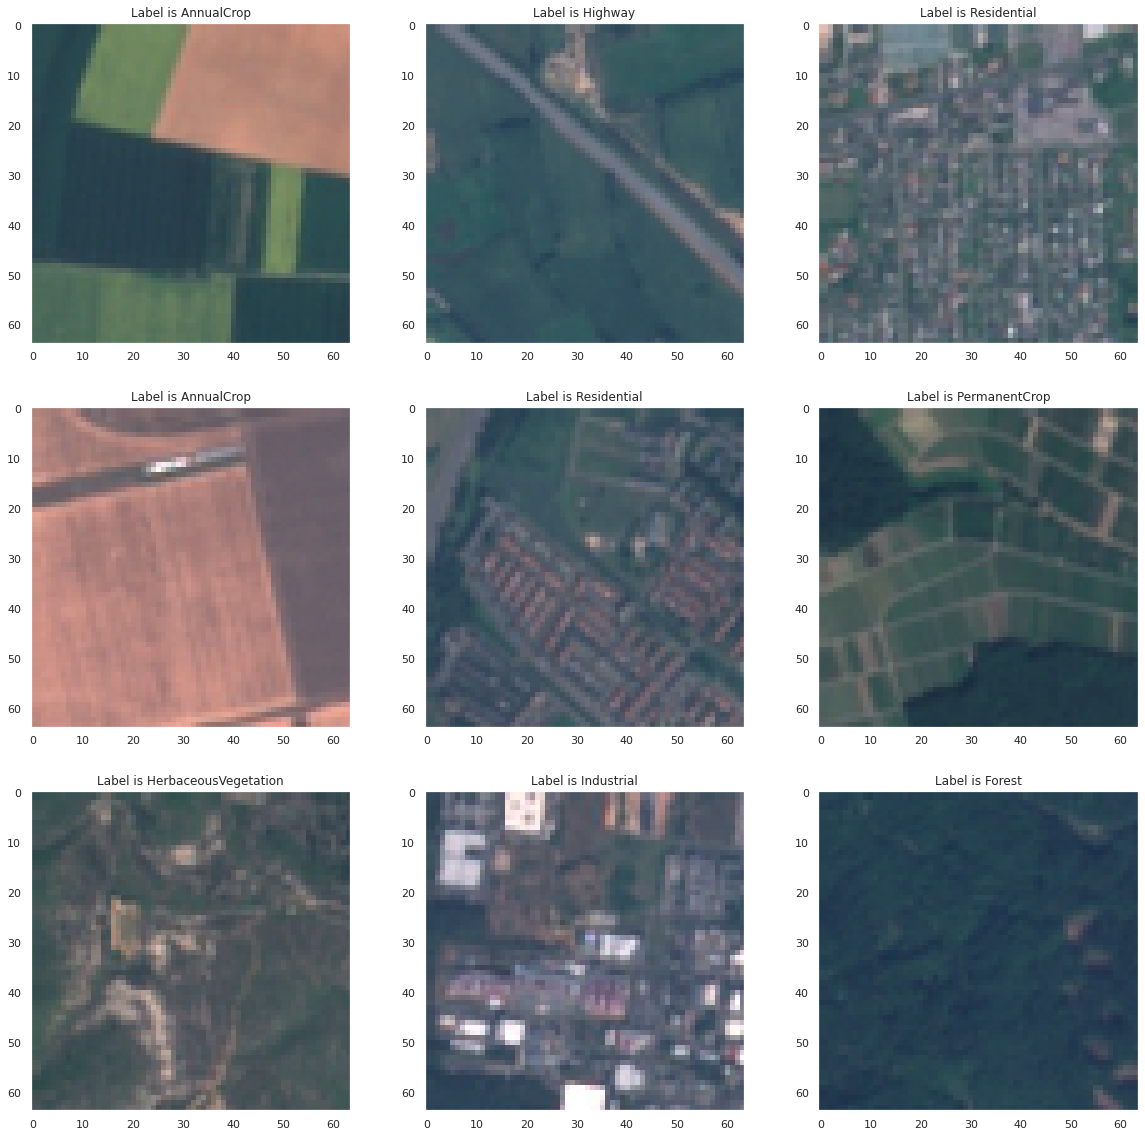

In [18]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

cols, rows = 3, 3
figure = plt.figure(figsize=(20, 20))
for X, y in test_dataloader:
    for i in range(1, cols*rows + 1): #show 10 images and their labels
        figure.add_subplot(rows, cols, i)
        plt.title(f"Label is {int2label[y[i].item()]}")
        plt.imshow(X[i,:,:,:].permute(1, 2, 0))
        plt.grid(False)
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
plt.show()

In [7]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*64*3, 512), #(w x h x c, output_dim)
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
torch.manual_seed(0)
epochs = 20
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")

Epoch 1
-------------------------------
loss: 2.290120  [    0/21600]
loss: 2.282696  [ 6400/21600]
loss: 2.268704  [12800/21600]
loss: 2.233057  [19200/21600]
Test Error: 
 Accuracy: 12.1%, Avg loss: 2.252893 

Epoch ran in 8.95 seconds
Epoch 2
-------------------------------
loss: 2.233880  [    0/21600]
loss: 2.263973  [ 6400/21600]
loss: 2.243823  [12800/21600]
loss: 2.194305  [19200/21600]
Test Error: 
 Accuracy: 13.7%, Avg loss: 2.222152 

Epoch ran in 8.05 seconds
Epoch 3
-------------------------------
loss: 2.198951  [    0/21600]
loss: 2.237712  [ 6400/21600]
loss: 2.218063  [12800/21600]
loss: 2.157060  [19200/21600]
Test Error: 
 Accuracy: 18.3%, Avg loss: 2.185713 

Epoch ran in 7.86 seconds
Epoch 4
-------------------------------
loss: 2.163037  [    0/21600]
loss: 2.201164  [ 6400/21600]
loss: 2.184206  [12800/21600]
loss: 2.112268  [19200/21600]
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.139201 

Epoch ran in 7.81 seconds
Epoch 5
-------------------------------
loss: 2.

In [12]:
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for X,y in test_dataloader:
        X.to(device)
        test_predictions += [model(X.to(device)).argmax(1)]
        test_labels += [y]
test_predictions = torch.cat(test_predictions)
test_labels = torch.cat(test_labels)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
c_mat = confusion_matrix(test_labels, test_predictions.cpu())

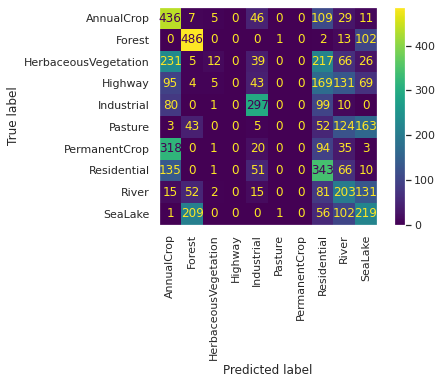

In [15]:
ConfusionMatrixDisplay(c_mat, display_labels=class_labels).plot(xticks_rotation='vertical')
ax = plt.gca()
ax.grid(False)
plt.show()